### Trains model

In [1]:
import os 
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efn
import tensorflow as tf
import keras

CFG_NAME = "eb0" # name of the configuration
ROOT_DIR = os.path.abspath("../")


DATASET_NAME = "isolated-beat-images" 
TRAIN_DATA_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME ,"train")
VALID_DATA_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME ,"val")
TEST_DATA_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_NAME ,"test")


if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
# Make log path to store all results
LOG_PATH = os.path.join(ROOT_DIR, "logs", CFG_NAME)
    
# Make new directory
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
    
       
# Open log file
log_file = open("{}/{}_log.out".format(LOG_PATH, CFG_NAME), 'w')
#sys.stdout = log_file

Using TensorFlow backend.


### Load dataset

In [2]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


def processing_func(img):
    # do sth
    return img


# Size of image
image_size = (128, 192)
batch_size = 64

# Use augmentations
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest',
        preprocessing_function=None)


# No augmentations
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size
)

validation_generator = validation_datagen.flow_from_directory(
    VALID_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size,
    shuffle=False
)

Found 60051 images belonging to 2 classes.
Found 23925 images belonging to 2 classes.
Found 23628 images belonging to 2 classes.


In [3]:
x, y = next(iter(test_generator))
x.shape, y.shape

((64, 128, 192, 3), (64, 2))

[1. 0.]


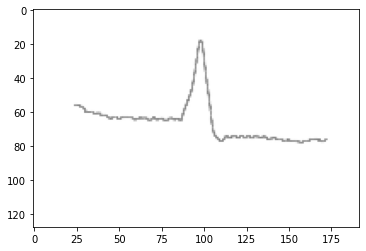

In [4]:
print(y[0])
plt.imshow(x[0])

### Define model

In [5]:
from keras.layers import Input, Conv2D, Dense
from keras.models import Model
from keras.optimizers import Adam

def classification_network():
    
    # Pre-trained model
    base_model = efn.EfficientNetB0(weights='imagenet',include_top=False,pooling='avg',input_shape=(128, 192, 3))
    
    # Add FC layer
    predictions = Dense(2, activation='softmax', trainable=True)(base_model.output) 
    
    # Unfreeze layers
    for layer in base_model.layers:
        layer.trainable=True
    
    # Build model
    model = Model(inputs=[base_model.input], outputs=[predictions])
        
    # Optimzer
    optim = Adam(lr=1e-5)

    # Loss function
    loss_func = 'binary_crossentropy' 
    
    model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
    return model

model = None
model = classification_network()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 192, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 96, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 96, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 96, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

### Set callbacks

In [6]:
# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(LOG_PATH, CFG_NAME), verbose=1, monitor='val_accuracy', save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, verbose=1, patience=5, mode='max'),
    keras.callbacks.CSVLogger('{}/training.csv'.format(LOG_PATH)),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=8, restore_best_weights=True)
]

### Class weights for data imbalance

In [7]:
#Define class weights for imbalacned data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
print(class_weights)

[0.73738304 1.55315022]


/home/hasib/anaconda3/envs/ecg/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Train model

In [8]:
start_time = time.time()

history = model.fit_generator(train_generator, 
                    epochs=500, validation_data = validation_generator, 
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks=callbacks, shuffle=True)

end_time = time.time()
print("--- Time taken to train : %s min ---" % ((end_time - start_time)//60))

Epoch 1/500
939/939 [==============================] - 257s 273ms/step - loss: 0.4683 - accuracy: 0.7763 - val_loss: 0.6298 - val_accuracy: 0.6514

Epoch 00001: val_accuracy improved from -inf to 0.65137, saving model to /home/hasib/hasib/ecg-heart/logs/eb0/eb0.h5
Epoch 2/500
939/939 [==============================] - 246s 262ms/step - loss: 0.2646 - accuracy: 0.8960 - val_loss: 0.5374 - val_accuracy: 0.7080

Epoch 00002: val_accuracy improved from 0.65137 to 0.70796, saving model to /home/hasib/hasib/ecg-heart/logs/eb0/eb0.h5
Epoch 3/500
939/939 [==============================] - 249s 265ms/step - loss: 0.1748 - accuracy: 0.9383 - val_loss: 0.2929 - val_accuracy: 0.8105

Epoch 00003: val_accuracy improved from 0.70796 to 0.81049, saving model to /home/hasib/hasib/ecg-heart/logs/eb0/eb0.h5
Epoch 4/500
939/939 [==============================] - 253s 270ms/step - loss: 0.1340 - accuracy: 0.9566 - val_loss: 0.2661 - val_accuracy: 0.9156

Epoch 00004: val_accuracy improved from 0.81049 to 

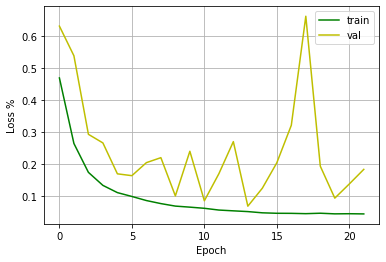

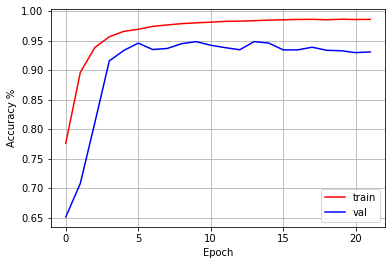

Done training and logging!


In [9]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()
    
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()

plot_loss_accu(history)
print("Done training and logging!")

### Load best weights and test model performance

In [4]:
from keras.models import load_model

model = None
model = load_model("{}/{}.h5".format(LOG_PATH, CFG_NAME), compile = False)

In [27]:
from keras.utils import np_utils

validation_generator = validation_datagen.flow_from_directory(
    VALID_DATA_PATH,
    target_size=image_size,
    class_mode='categorical',
    batch_size = batch_size,
    shuffle=False
)

# Validation labels
y_test_flat = validation_generator.classes
y_test = np_utils.to_categorical(y_test_flat, 2)

# Make preds
y_pred = model.predict_generator(validation_generator)

print(y_test.shape, y_pred.shape)

Found 23925 images belonging to 2 classes.
(23925, 2) (23925, 2)


In [28]:
def show_results(y, yhat):
    """
    y and yhat are 2D arrays of shape (N, 2)
    """
    # Flatten predictions
    yf = np.array([np.argmax(pred) for pred in y]) 
    yhatf = np.array([np.argmax(pred) for pred in yhat]) 
    
    from sklearn.metrics import accuracy_score
    # Accuracy
    acc = accuracy_score(yf, yhatf) * 100
    print("Accuracy : {:.2f}".format(acc))

    from sklearn.metrics import classification_report

    # Classification report
    target_names = ['0', '1']
    print("Classification report: ")
    print(classification_report(yf, yhatf, target_names=target_names, digits=4))
    
    #from sklearn.metrics import roc_auc_score
    #print('Area under ROC curve :{:.3f}'.format(roc_auc_score(y, yhat)))
    
    
    from sklearn.metrics import roc_curve, auc
    # https://github.com/hasibzunair/uniformizing-3D/blob/master/graph_compare.ipynb

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], yhat[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    cls = 1 # class name
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), yhat.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #print(roc_auc)
    print("Area under the ROC curve for positive class: {:.3f}".format(roc_auc[cls]))
    
    plt.figure()
    lw = 2 # line width
    plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = {:.3f})'.format(roc_auc[cls]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


Val data
Accuracy : 94.84
Classification report: 
              precision    recall  f1-score   support

           0     0.9569    0.9701    0.9634     16777
           1     0.9274    0.8975    0.9122      7148

    accuracy                         0.9484     23925
   macro avg     0.9422    0.9338    0.9378     23925
weighted avg     0.9481    0.9484    0.9481     23925

Area under the ROC curve for positive class: 0.973


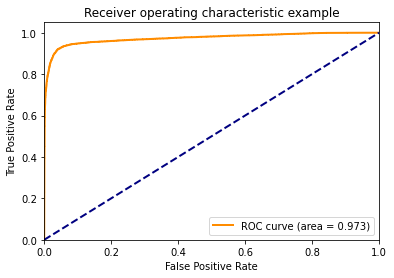

In [29]:
print("Val data")
show_results(y_test, y_pred)

### Test peformance

In [23]:
# Test labels
y_test_flat = test_generator.classes
y_test = np_utils.to_categorical(y_test_flat, 2)

# Make preds
y_pred = model.predict_generator(test_generator)

Test data
Accuracy : 78.57
Classification report: 
              precision    recall  f1-score   support

           0     0.8979    0.8020    0.8473     17510
           1     0.5660    0.7391    0.6411      6118

    accuracy                         0.7857     23628
   macro avg     0.7320    0.7706    0.7442     23628
weighted avg     0.8120    0.7857    0.7939     23628

Area under the ROC curve for positive class: 0.827


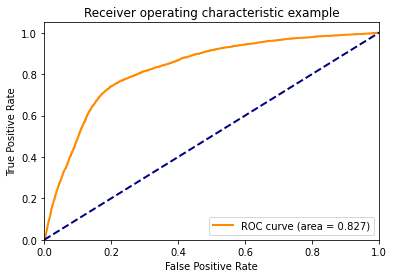

In [25]:
print("Test data")
show_results(y_test, y_pred)

In [16]:
print("------------------------------------End of script------------------------------------")

------------------------------------End of script------------------------------------
